## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
# import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
# CFG = {
#     'X_RANGE':3, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
#     'EPOCHS':100,
#     'LEARNING_RATE':5e-2,
#     'BATCH_SIZE':128,
#     'SEED':19
# }

CFG = {
    'X_RANGE':2, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS':130,
    'LEARNING_RATE':5e-2,
    'BATCH_SIZE':64,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [5]:
train_df = pd.read_csv('./train.csv')

In [6]:
train_df

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308
...,...,...,...,...,...
1456,20211227,3.830,3.416,2.908,2.350
1457,20211228,4.510,3.890,3.714,2.700
1458,20211229,4.490,3.524,3.660,2.524
1459,20211230,4.444,3.574,3.530,2.506


In [7]:
tp = pd.DataFrame()
for i in range(4):
    tp = pd.concat([tp,train_df.loc[365*i:365*i+334:,:]],axis=0)

In [8]:
train_df = tp

## Data Visualization

In [9]:
# def get_view_df(df, target):
#     viewd = df[['일시', target]]
#     viewd = viewd.reset_index(drop=True)
#     viewd = viewd.reset_index()
#     print(target)
#     sns.set(rc = {'figure.figsize':(30,8)})
#     sns.lineplot(x='index', y=target, data=viewd)
#     plt.show()

In [10]:
# get_view_df(train_df, '광진구')
# get_view_df(train_df, '동대문구')
# get_view_df(train_df, '성동구')
# get_view_df(train_df, '중랑구')

## Train / Validation Split

In [11]:
val_df = train_df.iloc[334*3-CFG['X_RANGE']:].reset_index().drop(columns='index') # 20210101 ~ 20211231
# 위의 1096-CFG['X_RANGE']의 이유는 20210101을 예측하기 위해서는 이전 X_RANGE만큼의 일수가 필요하므로
train_df = train_df.iloc[:334*3].reset_index().drop(columns='index') # 20180101 ~ 20201231

## Data Pre-processing

In [12]:
def get_x_y_data(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, ['합','년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]).astype(float))
        y_data.append(np.array(df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [13]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[4:6].astype(int)/12.
    df['일'] = df['일시'].str[6:8].astype(int)/31.
    df['합'] = df['광진구']/4 + df['동대문구']/4 + df['성동구']/4 + df['중랑구']/4
    df = df[['합','년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]
    return df

In [14]:
train_df = make_ymd_feature(train_df)
val_df = make_ymd_feature(val_df)

In [15]:
train_x, train_y = get_x_y_data(train_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
val_x, val_y = get_x_y_data(val_df)

  0%|          | 0/338 [00:00<?, ?it/s]

## CustomDataset

In [17]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        else:
            return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [18]:
train_dataset = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Define Model

In [19]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=8, hidden_size=256, num_layers=4, batch_first=True)
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=4),
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:,-1,:])
        return output

## Train

In [20]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        val_mae = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val MAE : [{val_mae:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_mae)
            
        if best_loss > val_mae:
            best_loss = val_mae
            best_model = model 
    return best_model

In [21]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss    

## Run!!

In [22]:
model = BaseModel()

In [23]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4,threshold_mode='abs',min_lr=1e-10, verbose=True)
best_model = train(model, optimizer, train_loader, val_loader, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [2.65814] Val MAE : [6.33555]
Epoch : [2] Train Loss : [1.92092] Val MAE : [10.30255]
Epoch : [3] Train Loss : [2.09146] Val MAE : [28.03802]
Epoch : [4] Train Loss : [2.10852] Val MAE : [27.10431]
Epoch : [5] Train Loss : [2.10645] Val MAE : [19.99263]
Epoch : [6] Train Loss : [2.10085] Val MAE : [21.77156]
Epoch : [7] Train Loss : [2.11881] Val MAE : [63.97347]
Epoch : [8] Train Loss : [2.14202] Val MAE : [66.89589]
Epoch : [9] Train Loss : [2.10759] Val MAE : [49.24127]
Epoch : [10] Train Loss : [1.86038] Val MAE : [1381.22679]
Epoch : [11] Train Loss : [1.68081] Val MAE : [289.40423]
Epoch : [12] Train Loss : [1.71225] Val MAE : [413.62126]
Epoch : [13] Train Loss : [1.36614] Val MAE : [297.79486]
Epoch : [14] Train Loss : [1.34471] Val MAE : [564.16221]
Epoch : [15] Train Loss : [1.35714] Val MAE : [103.53958]
Epoch 00015: reducing learning rate of group 0 to 2.5000e-02.
Epoch : [16] Train Loss : [1.30729] Val MAE : [90.37854]
Epoch : [17] Train Loss : [1.

Epoch : [123] Train Loss : [1.16003] Val MAE : [1.85413]
Epoch : [124] Train Loss : [1.16450] Val MAE : [1.87190]
Epoch : [125] Train Loss : [1.15754] Val MAE : [1.88027]
Epoch : [126] Train Loss : [1.14873] Val MAE : [1.87066]
Epoch : [127] Train Loss : [1.18017] Val MAE : [1.88444]
Epoch : [128] Train Loss : [1.16143] Val MAE : [1.88523]
Epoch : [129] Train Loss : [1.17038] Val MAE : [1.86975]
Epoch : [130] Train Loss : [1.16193] Val MAE : [1.87927]


## Inference

In [24]:
test_df = pd.read_csv('./sample_submission.csv')
test_df = make_ymd_feature(test_df)
test_df = pd.concat([val_df[CFG['X_RANGE']*(-1):], test_df]).reset_index().drop(columns='index')

In [25]:
test_df

,합,년,월,일,광진구,동대문구,성동구,중랑구
0,6.829,2.021,0.916667,0.935484,8.454,7.214,6.676,4.972
1,2.066,2.021,0.916667,0.967742,2.648,2.326,1.784,1.506
2,0.000,2.022,0.083333,0.032258,0.000,0.000,0.000,0.000
3,0.000,2.022,0.083333,0.064516,0.000,0.000,0.000,0.000
4,0.000,2.022,0.083333,0.096774,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...
331,0.000,2.022,0.916667,0.838710,0.000,0.000,0.000,0.000
332,0.000,2.022,0.916667,0.870968,0.000,0.000,0.000,0.000
333,0.000,2.022,0.916667,0.903226,0.000,0.000,0.000,0.000
334,0.000,2.022,0.916667,0.935484,0.000,0.000,0.000,0.000


In [26]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, ['합','년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']] = model_pred
    return df.loc[CFG['X_RANGE']:, ['광진구', '동대문구', '성동구', '중랑구']].reset_index().drop(columns=['index'])

In [27]:
preds = inference(best_model, test_df, device)

  0%|          | 0/334 [00:00<?, ?it/s]

## Submission

In [28]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0


In [29]:
submit['광진구'] = preds['광진구']
submit['동대문구'] = preds['동대문구']
submit['성동구'] = preds['성동구']
submit['중랑구'] = preds['중랑구']

<AxesSubplot:>

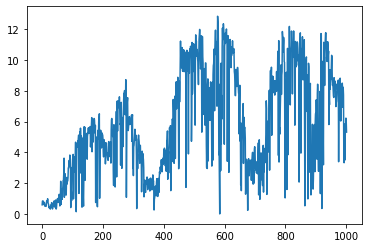

In [30]:
train_df['광진구'].plot()

<AxesSubplot:>

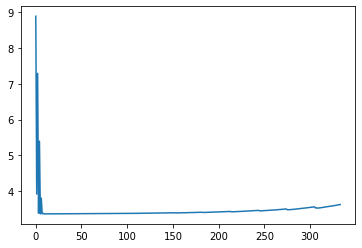

In [31]:
submit['광진구'].plot()

In [32]:
# year = 1
# import numpy as np
# X = [[i] for i in list(range(365*year,365*year+334))]
# y = train_df.loc[365*year:365*year+333,'광진구']
# from sklearn.preprocessing import PolynomialFeatures

# poly_features = PolynomialFeatures(degree=5,include_bias=True)
# X_poly = poly_features.fit_transform(X)

# from sklearn.linear_model import LinearRegression

# lin_reg = LinearRegression()
# lin_reg.fit(X_poly, y)
# lin_reg.intercept_ , lin_reg.coef_
# pred = lin_reg.predict(poly_features.fit_transform(X))
# plt.plot(X,pred)

# train_df.loc[365*year:365*year+334,'광진구'].plot()
# submit['광진구'] = pred

# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(y,pred)

In [33]:
# year = 3
# pred_year = 2
# city = '중랑구'
# import numpy as np
# X = [[i] for i in list(range(365*year,365*year+334))]
# y = train_df.loc[365*year:365*year+333,city]
# from sklearn.preprocessing import PolynomialFeatures

# poly_features = PolynomialFeatures(degree=4,include_bias=True)
# X_poly = poly_features.fit_transform(X)

# from sklearn.linear_model import LinearRegression

# lin_reg = LinearRegression()
# lin_reg.fit(X_poly, y)
# lin_reg.intercept_ , lin_reg.coef_
# pred = lin_reg.predict(poly_features.fit_transform(X))
# plt.plot(X,pred)

# train_df.loc[365*year:365*year+334, city].plot()
# submit[city] = pred

# from sklearn.metrics import mean_absolute_error
# target_y = train_df.loc[365*(pred_year):365*(pred_year)+333,city]
# mean_absolute_error(target_y,pred)

<AxesSubplot:>

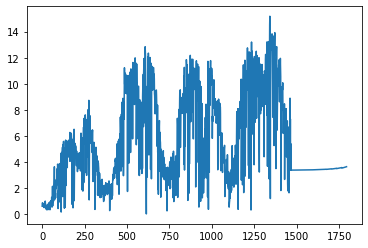

In [34]:
train_df = pd.read_csv('./train.csv')
pd.concat([train_df,submit]).reset_index()['광진구'].plot()

<AxesSubplot:>

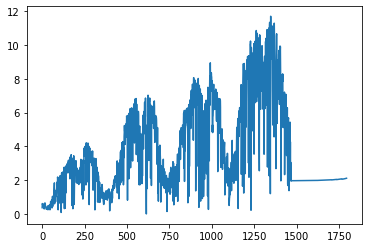

In [35]:
pd.concat([train_df,submit]).reset_index()['동대문구'].plot()

<AxesSubplot:>

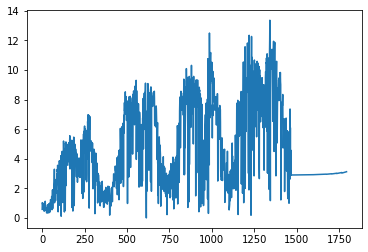

In [36]:
pd.concat([train_df,submit]).reset_index()['성동구'].plot()

<AxesSubplot:>

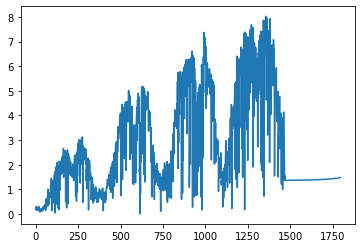

In [37]:
pd.concat([train_df,submit]).reset_index()['중랑구'].plot()

In [38]:
submit.to_csv('./submit.csv', index=False)

In [39]:
temp = pd.read_csv('./submit.csv')
temp['광진구'] = temp['광진구']*1.5
temp['동대문구'] = temp['동대문구']*1.8
temp['성동구'] = temp['성동구']*1.6
temp['중랑구'] = temp['중랑구']*1.6
temp.to_csv('./submit1.csv', index=False)

<AxesSubplot:>

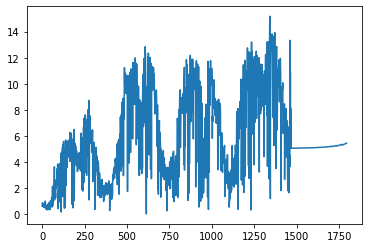

In [40]:
pd.concat([train_df,submit*1.5]).reset_index()['광진구'].plot()

<AxesSubplot:>

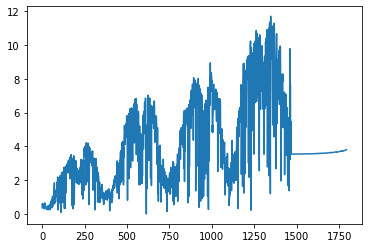

In [41]:
pd.concat([train_df,submit*1.8]).reset_index()['동대문구'].plot()

<AxesSubplot:>

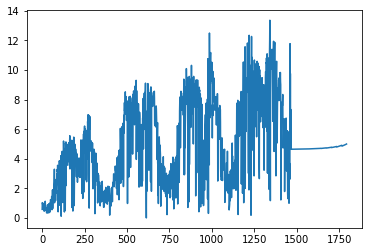

In [42]:
pd.concat([train_df,submit*1.6]).reset_index()['성동구'].plot()

<AxesSubplot:>

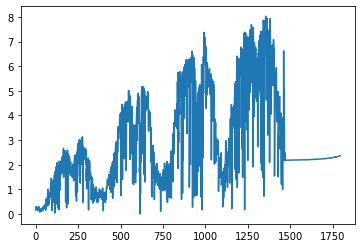

In [43]:
pd.concat([train_df,submit*1.6]).reset_index()['중랑구'].plot()

In [44]:
train_df = pd.read_csv('./train.csv')

In [45]:
train_df

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308
...,...,...,...,...,...
1456,20211227,3.830,3.416,2.908,2.350
1457,20211228,4.510,3.890,3.714,2.700
1458,20211229,4.490,3.524,3.660,2.524
1459,20211230,4.444,3.574,3.530,2.506


<AxesSubplot:>

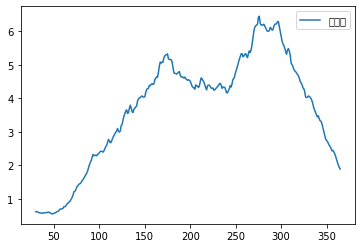

In [57]:
pd.DataFrame(train_df['광진구'].rolling(30,axis=0).mean()).loc[30:365].plot()

<AxesSubplot:>

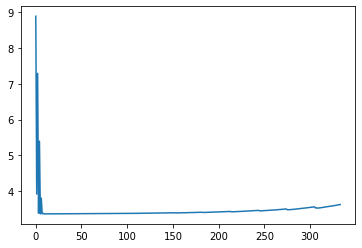

In [50]:
pd.read_csv('./submit.csv')

<AxesSubplot:>

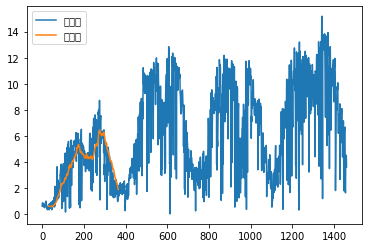

In [71]:
train_df = pd.read_csv('./train.csv')

pd.concat([train_df.loc[:,'광진구'],pd.DataFrame(train_df['광진구'].rolling(30,axis=0).mean()).loc[30:365]],axis=1).reset_index()['광진구'].plot()
